# Notebook for visualisation, running the timeline analysis

This notebook is both a testing ground but also building towards the next steps of data collection/analyses in this study. This notebook comes after the FAS data collection step until 2020-10-17. So next steps include any clustering results and visualisation, collection of the next set of data, and the subsequent statistical matching and analysis of these users.

Create timeline analyzer object

In [1]:
from bispec_clustering_eval import BSCresults
from timeline_analysis import TimelineAnalyzer
import numpy as np
import plotnine
import os
import pandas as pd
import datetime
import pickle
import re
import scipy.signal
import matplotlib.pyplot as plt
import glob
import tqdm
import jsonlines

bscres = TimelineAnalyzer('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/bsc', '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/data')


Process the existing clustering data and determine best user and phrase clusters.

In [2]:
results = bscres.eval_nmi()
print('user index and cluster num: {}'.format(results[0][1:]))
print(results[1][1:])

user index and cluster num: (164, 174)
(167, 177)


Plot the evaluation plots for cluster values

In [3]:
bscres.plot(bins=100, verbose = False)

Exmining cluster words is available

In [4]:
x = bscres.examine_cluster_words(149, 106, show=0)
x

,hashtag,degree,topic_cluster
45,#balancetonporc,5188,106
47,#espagne,14,106
48,#femmes,112,106
49,#fi,55,106
50,#fn,69,106
...,...,...,...
69201,une mosquée de kaboul,10,106
69202,xiaomi mi mix,10,106
70593,la parole des,18,106
72575,#dénoncelestruies,69,106


Just for the purposes of this notebook, loading in a previously saved vocab object.

In [5]:
if os.path.isfile('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/bsc/149_106_user_data.obj'):
    with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/bsc/149_106_user_data.obj','rb') as f:
        bscres.df = pickle.load(f)
        df = bscres.df
else:
    df = bscres.get_user_cluster_data(149,6)

In [6]:
df

,author_id,tweet_id,text,created_at,referenced_tw_1,referenced_tw_2,referenced_tw_3,is_retweet,internal_retweet,vocab:#balancetonporc,...,vocab:sur la foune,vocab:sur les produits,vocab:sébastien le fol,vocab:sébastien le fol après,vocab:une mosquée de,vocab:une mosquée de kaboul,vocab:xiaomi mi mix,vocab:la parole des,vocab:#dénoncelestruies,vocab:libérer la parole
0,100496102,922570840696242177,RT @mathieugallard: En vue des européennes de ...,2017-10-23 21:10:03,922465252029157376,NaN,NaN,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,100496102,922570372121206784,RT @WWFFrance: 🐱 Journée mondiale du #léopard ...,2017-10-23 21:08:11,922375797377327104,NaN,NaN,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,100496102,922570075835473920,Une erreur de 10 milliards d'euro commise par ...,2017-10-23 21:07:01,NaN,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,100496102,922567680527286272,RT @JCLarsonneur: Retrouvez la tribune cosigné...,2017-10-23 20:57:30,922563966273970176,NaN,NaN,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,100496102,922566329311170560,Harcèlement &amp; agression sexuelle : 40 femm...,2017-10-23 20:52:08,NaN,NaN,NaN,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,99086843,917715109094490112,@lithadem Ah bon! J'aurais cru que relation sa...,2017-10-10 11:35:06,917672088055541762,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1374,99086843,917671291909496832,@lithadem A priori quand meme pour la majorité...,2017-10-10 08:41:00,917670310266245121,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1375,99086843,917660501886324736,@Sou_fak @Ostpolitik C moche visuellemt&amp;pa...,2017-10-10 07:58:07,917457083959840768,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1376,99086843,917658700004954112,RT @mistergrosbill: @Ostpolitik Pareil... just...,2017-10-10 07:50:58,917457565193265158,NaN,NaN,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
bscres.print_stats()

Number of tweets in df: 108564
Number of retweets in df: 73498
Percentage Retweets
Number of retweets of other users in the cluster: 0


## Plotting

### Plotting Full Archive Search Activity Plots

In [8]:
# save bscres.
if os.path.isfile('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/FAS_activity_df_long_with_zeros.obj'):
    with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/FAS_activity_df_long_with_zeros.obj','rb') as f:
        bscres.FAS_activity_df_long_with_zeros = pickle.load(f)
else:
    bscres.plot_FAS_activity('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/search_hashtags.txt')
    with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/FAS_activity_df_long_with_zeros.obj','wb') as f:
        pickle.dump(bscres.FAS_activity_df_long_with_zeros, f)

## Get peaks of each hashtag for the second step of data collection

### Pad the counts for each hashtag so that there are no missing days

In [9]:
bscres.FAS_activity_df_long_with_zeros['created_at'] = pd.to_datetime(bscres.FAS_activity_df_long_with_zeros['created_at'])
bscres.FAS_activity_df_long_with_zeros = bscres.FAS_activity_df_long_with_zeros.set_index('created_at')

In [10]:
def reindex_by_date(df):
    df = df.reindex(pd.date_range(datetime.datetime(2017,10,16), datetime.
    datetime(2020,10,15)), fill_value = 0)
    df['hashtag'] = df['hashtag'].replace(to_replace=0, method='ffill')
    return df

# print(len(bscres.FAS_activity_df_long))
z = bscres.FAS_activity_df_long_with_zeros.groupby('hashtag').apply(reindex_by_date).reset_index(0,drop=True).reset_index().rename(columns={'index':'created_at'})
# z = bscres.FAS_activity_df_long_with_zeros.groupby('hashtag').apply(lambda x: x.reindex(pd.date_range(datetime.datetime(2017,10,16), datetime.datetime(2020,10,15)), fill_value=0))
z['vocab:#'] = z['vocab:#'].astype(int)
# print(z)
assert bscres.FAS_activity_df_long_with_zeros['vocab:#'].sum() == z['vocab:#'].sum()
# print(len(z[z['hashtag']=='metoo']))
bscres.FAS_activity_df_long_with_zeros = z
assert (bscres.FAS_activity_df_long_with_zeros.groupby('hashtag').count()['vocab:#']==1096).all()

In [11]:
# try again with prominence parameter.
results = []
for hashtag in bscres.FAS_activity_df_long_with_zeros['hashtag'].unique():

    assert len(bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]) == 1096
    z = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]['vocab:#']
    peaks, peak_properties = scipy.signal.find_peaks(
        z,
        prominence = 0.9,
        distance=28,
        height = 0.05*max(z)
    )
    results.append((hashtag, peaks, peak_properties))

In [12]:
#print hashtags with no detected peaks:
for index, peakdetection in enumerate(results):
    if len(peakdetection[1]) == 0:
        print('{} at index {} has no peaks detected.'.format(peakdetection[0], index))

وأنا كمان at index 30 has no peaks detected.


In [13]:
# this is because no instances of this hashtag were actually scraped. Possibly to be investigated, more likely just scrap it.
bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==results[6][0]]['vocab:#'].max()

25634

In [14]:
for index,peakdetection in enumerate(results):

    # unique_hashtags = bscres.FAS_activity_df_long_with_zeros['hashtag'].unique()

    x = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==peakdetection[0]].loc[:,['vocab:#']] 

    # just check if figures already exist
    filename = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/'+peakdetection[0]+'.jpg'

    # if os.path.isfile(filename):
    #     print('not graphing {} as file already exists'.format(peakdetection[0]))
    #     continue

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(x.reset_index().loc[:,'vocab:#'])
    plt.plot(results[index][1], x.reset_index().loc[results[index][1],'vocab:#'].values.flatten(),"x")
    plt.savefig(filename,bbox_inches='tight')
    plt.close()

In [15]:
# continuity check
for hashtag in bscres.FAS_activity_df_long_with_zeros['hashtag'].unique():
    z = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]
    first = datetime.datetime.strptime('2017-10-16', '%Y-%m-%d')
    for index,i in enumerate(z['created_at']):
        assert i == first, (index, i)
        first += datetime.timedelta(days=1)
print('all okay')

all okay


## Determining the users to collect

In [16]:
# From the peaks collected, determine a window around each one to collect users from and get user ids to collect.

import re
import jsonlines
import datetime
import glob
import tqdm

def FAS_dates(FAS_filename):
    return re.split('[_.]',FAS_filename)[1:3]

print(FAS_dates('FAS_2017-10-16_2017-11-16.jsonl'))

# now sanity check: which dates are inclusive?
flist = glob.glob('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data/FAS*.jsonl')

# for file in tqdm.tqdm(flist):
#     times=[]
#     with jsonlines.open(file) as reader:
#         for tweet_jsonl in reader:
#             tweet_list_in_file = tweet_jsonl['data']
#             for tweet_data in tweet_list_in_file:
#                 times.append(datetime.datetime.fromisoformat(tweet_data['created_at'][:-1]))
#     assert datetime.datetime.strptime(FAS_dates(os.path.split(file)[1])[1],'%Y-%m-%d') > max(times)

# print(min(times), max(times))

# N.B. END DATES OF FAS FILE TITLES ARE NOT INCLUSIVE


['2017-10-16', '2017-11-16']


In [17]:
for i,e in enumerate(results):
    if e[0] == 'metoo':
        metoo_index = i
        break

In [18]:
# collate peak locations

# first, take the peak locations of #metoo and treat those as bases around which to start collection. This strategy does NOT contain peaks taht are not around #metoo peaks. THIS MAY NEED TO BE REVISED OR ADDED TO

ranges = []
width = 21 # number of days to colelct before and after each peak
for index, peak in enumerate(results[metoo_index][1]):
    ranges.append((max(0,peak-width), min(peak+width, 1096)))

print(ranges)

def review_ranges(ranges):

    # define output list
    new_ranges = []

    for index in range(len(ranges)):
        if len(new_ranges) > 0 and new_ranges[-1][1]>=ranges[index][0]:
            continue
        else:
            prospective_pair = ranges[index]
        ranges_index = index
        if index+1 == len(ranges):
            new_ranges.append(prospective_pair)
            break

        # create prospective pair
        if ranges[index][1] >= ranges[ranges_index+1][0]:
            prospective_pair = (ranges[index][0], ranges[ranges_index+1][1])
            ranges_index += 1
        while prospective_pair[1] >= ranges[ranges_index+1][0]:
            # print(prospective_pair)

            if prospective_pair[1] >= ranges[ranges_index+1][1]:

                prospective_pair = (ranges[index][0], prospective_pair[1])
                ranges_index += 1

            elif prospective_pair[1] < ranges[ranges_index+1][1]:

                prospective_pair = (ranges[index][0], ranges[ranges_index+1][1])
                ranges_index += 1

        new_ranges.append(prospective_pair)

    return new_ranges
print(results[metoo_index][1])
print(review_ranges(ranges))

def range_strengths(reviewed_ranges, results):
    prominences = []
    for pair in reviewed_ranges:
        pair_prominence = 0
        # start at [1:] to skip #metoo
        no_peaks = True
        for hashtag_peaks in results[1:]:
            for index, peak in enumerate(hashtag_peaks[1]):
                if peak > pair[0] and peak <= pair[1]:
                    no_peaks = False
                    pair_prominence += hashtag_peaks[2]['prominences'][index]
        if no_peaks:
            prominences.append(0)
        else:
            prominences.append(pair_prominence)

    return prominences

prominences = range_strengths(review_ranges(ranges), results)
print(prominences)

width_normalised_prominences = [prom/(width[1]-width[0]) for width, prom in zip(review_ranges(ranges), prominences)]

[(0, 27), (30, 72), (63, 105), (95, 137), (123, 165), (152, 194), (183, 225), (242, 284), (307, 349), (340, 382), (401, 443), (512, 554), (772, 814), (840, 882), (906, 948), (1049, 1091)]
[   6   51   84  116  144  173  204  263  328  361  422  533  793  861
  927 1070]
[(0, 27), (30, 225), (242, 284), (307, 382), (401, 443), (512, 554), (772, 814), (840, 882), (906, 948), (1049, 1091)]
[14655.0, 833297.0, 59616.0, 157086.0, 92539.0, 38486.0, 38044.0, 126594.0, 65590.0, 47499.0]


In [19]:
# converting 0-1083 back to dates

def unit_conv(val):
        return datetime.datetime.strptime('2017-10-16', '%Y-%m-%d') + datetime.timedelta(days=int(val))

def conv_to_date_ranges(ranges):
    return_ranges = []

    for pair in ranges:
        return_ranges.append((unit_conv(pair[0]), unit_conv(pair[1])))

    return return_ranges

dated_reviewed_ranges = conv_to_date_ranges(review_ranges(ranges))
# print(dated_reviewed_ranges)


[0.12701554 1.         0.33216077 0.49012969 0.51559691 0.21443135
 0.21196867 0.70534018 0.36544593 0.26464882]


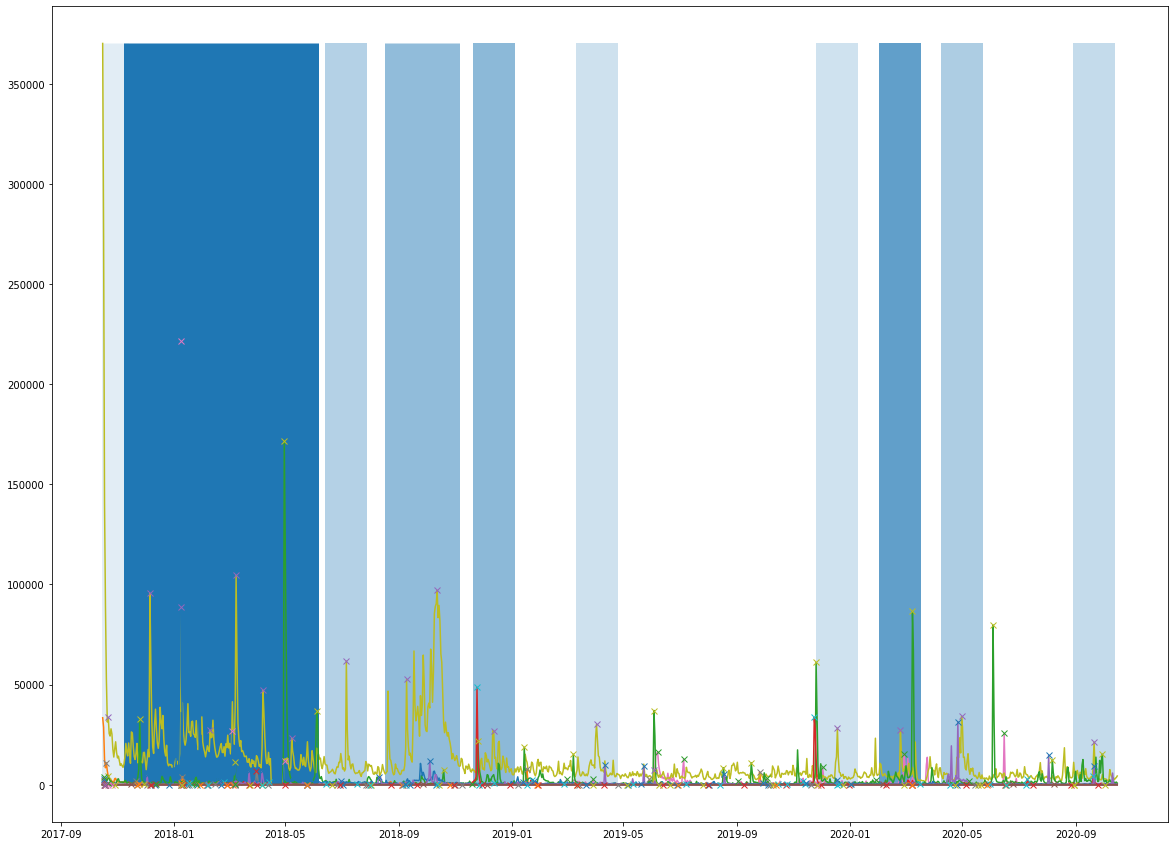

In [20]:
#visualising the parts of the graph that will be sampled
bscres.FAS_activity_df_long = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['vocab:#']!=0]

# convert to datetime objects in column
bscres.FAS_activity_df_long_with_zeros['created_at'] = pd.to_datetime(bscres.FAS_activity_df_long_with_zeros['created_at'])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.vlines([i[0]+0.5*(i[1]-i[0]) for i in dated_reviewed_ranges],
    ymin = 0,
    ymax = bscres.FAS_activity_df_long_with_zeros['vocab:#'].max(),
    linewidth = [(i[1]-i[0]).days for i in dated_reviewed_ranges],
    # linewidth = 5,
    alpha = width_normalised_prominences/max(width_normalised_prominences)
    );
wide_data = bscres.FAS_activity_df_long_with_zeros.pivot(index='created_at', columns='hashtag', values='vocab:#')
# plt.plot('created_at','vocab:#', data = bscres.FAS_activity_df_long)
plt.plot(wide_data);

# also plot detected peaks
for peaksdetections in results:

    converted_peaks = np.array([unit_conv(i) for i in peaksdetections[1]])
    peak_plot_data = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==peaksdetections[0]]
    peak_plot_data = peak_plot_data[peak_plot_data['created_at'].isin(converted_peaks)].loc[:,['created_at','vocab:#']]
    plt.plot('created_at', 'vocab:#', 'x', data = peak_plot_data, )

print(width_normalised_prominences/max(width_normalised_prominences))

# plt.semilogy(basey=2)


### Get the users required for second data collection for blocks selected.

In [21]:
# select blocks

print(pd.DataFrame(width_normalised_prominences/max(width_normalised_prominences)))

selected_blocks = [1,4,7]

# get date range for selected blocks:
selected_date_ranges = [dated_reviewed_ranges[i] for i in selected_blocks]
print(selected_date_ranges)

          0
0  0.127016
1  1.000000
2  0.332161
3  0.490130
4  0.515597
5  0.214431
6  0.211969
7  0.705340
8  0.365446
9  0.264649
[(datetime.datetime(2017, 11, 15, 0, 0), datetime.datetime(2018, 5, 29, 0, 0)), (datetime.datetime(2018, 11, 21, 0, 0), datetime.datetime(2019, 1, 2, 0, 0)), (datetime.datetime(2020, 2, 3, 0, 0), datetime.datetime(2020, 3, 16, 0, 0))]


In [22]:
# save selected date ranges.
pickle_path = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/selected_date_ranges.obj'
with open(pickle_path, 'wb') as f:
    pickle.dump(selected_date_ranges,f)

assert os.path.isfile(pickle_path)

In [23]:
import glob
import tqdm
import jsonlines

flist = glob.glob('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data/FAS*.jsonl')

user_sets = [[] for i in range(len(selected_blocks))]

for file in tqdm.tqdm(flist):
    times=[]
    with jsonlines.open(file) as reader:
        for tweet_jsonl in reader:
            tweet_list_in_file = tweet_jsonl['data']
            for tweet_data in tweet_list_in_file:
                tweet_created_at = datetime.datetime.fromisoformat(tweet_data['created_at'][:-1])
                for i,e in enumerate(selected_date_ranges):
                    if e[0] <= tweet_created_at <= e[1]:
                        user_sets[i].append(tweet_data['author_id'])

100%|██████████| 36/36 [55:42<00:00, 92.85s/it]


In [24]:
# print user_sets info
from collections import Counter
user_sets = [Counter(i) for i in user_sets]
user_sets = [i.most_common() for i in user_sets]
# users = [i[0] for i in users]

In [25]:
for i,e in enumerate(user_sets):
    print(selected_date_ranges[i], len(e))

(datetime.datetime(2017, 11, 15, 0, 0), datetime.datetime(2018, 5, 29, 0, 0)) 2488905
(datetime.datetime(2018, 11, 21, 0, 0), datetime.datetime(2019, 1, 2, 0, 0)) 564058
(datetime.datetime(2020, 2, 3, 0, 0), datetime.datetime(2020, 3, 16, 0, 0)) 664970


In [26]:
pickle_path = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_sets.obj'
with open(pickle_path, 'wb') as f:
    pickle.dump(user_sets,f)

assert os.path.isfile(pickle_path)

In [58]:
user_sets[0]

[('856380101084278785', 20189),
 ('805516112456581120', 10961),
 ('2971280040', 6468),
 ('2855078942', 5908),
 ('44983352', 5646),
 ('777310183', 3066),
 ('28861886', 2643),
 ('329813100', 2401),
 ('113349253', 2292),
 ('940021102910115840', 2247),
 ('708951308582199296', 2237),
 ('951547008845717504', 2233),
 ('1334420054', 2222),
 ('719003733997150208', 2160),
 ('482334246', 1986),
 ('970863549940666368', 1984),
 ('781390470123556864', 1923),
 ('868463655372734465', 1898),
 ('4491531140', 1807),
 ('808064484527009792', 1766),
 ('2502606786', 1757),
 ('849811472595247104', 1748),
 ('330509973', 1674),
 ('38975546', 1639),
 ('591291172', 1625),
 ('202924368', 1592),
 ('919964122959114240', 1429),
 ('2569898482', 1334),
 ('1939191715', 1314),
 ('47133638', 1263),
 ('317420738', 1252),
 ('505836008', 1187),
 ('1161952543', 1099),
 ('331317907', 1089),
 ('1497738242', 1071),
 ('610919499', 1066),
 ('4136555717', 1066),
 ('1879298496', 1060),
 ('550727163', 1039),
 ('1410109772', 1033),
 (

In [31]:
for i,e in enumerate(user_sets):

    user_list_full_fn = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_' + str(i) + '_.txt'
    
    print(user_list_full_fn)

/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_0_.txt
/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_1_.txt
/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_2_.txt


In [32]:
for i,e in enumerate(user_sets):

    user_list_full_fn = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_' + str(i) + '_.txt'

    with open(user_list_full_fn, 'w') as f:
        for j in e:
            f.write(','.join([str(s) for s in j]))
            f.write('\n')

    print('{} saved.'.format(os.path.split(user_list_full_fn)[1]))

user_list_full_0_.txt saved.
user_list_full_1_.txt saved.
user_list_full_2_.txt saved.


In [33]:
users_list_pd = pd.read_csv(
        '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_0_.txt',
        header=None,
        names=['user_id','tweet_count']
    )

In [74]:
z = users_list_pd.groupby('tweet_count').count()
print(z)
print('the number of users in total: {}'.format(sum(z['user_id'])))
k = len(users_list_pd[users_list_pd['tweet_count']>=90])
# 90 chosen just so over 6 months this approximates tweeting once every two days
print(k)
print(k/sum(z['user_id']))
print(selected_date_ranges[0])

# now need to sample of users who have participated. That is, sample 1000 users so that there is 10000 limit per user.

# plt.plot(z)
# plt.semilogy(basey=10)

             user_id
tweet_count         
1            1450422
2             399576
3             185657
4             106017
5              68813
...              ...
5646               1
5908               1
6468               1
10961              1
20189              1

[544 rows x 1 columns]
the number of users in total: 2488905
4339
0.0017433369292921988
(datetime.datetime(2017, 11, 15, 0, 0), datetime.datetime(2018, 5, 29, 0, 0))


In [40]:
# determine set intersections
intersections = np.ones(shape=(len(selected_date_ranges),len(selected_date_ranges)))

for i,e1 in enumerate(user_sets):
    for j,e2 in enumerate(user_sets):
        if i==j:
            continue
        else:
            intersections[i,j] = len(e1.intersection(e2))/len(e1)

print(intersections)

[[1.         0.09867311 0.07854659]
 [0.43539494 1.         0.1685199 ]
 [0.29399071 0.1429463  1.        ]]


In [ ]:
# save the collected user lists
# QUESTION 2021-09-10: should I specify NOT the already collected tweets in FAS in the second data collection?



### Plotting usage of vocab aggregated

In [ ]:
bscres.plot_usage_vocab()

In [ ]:
for vocab_entry in bscres.vocab_colnames[:1]:
    plot_savename = os.path.join(bscres.image_path, vocab_entry[1]+ ".png") 
    plot_data = bscres.df.loc[:,['created_at', vocab_entry[1]]]
    plot_data.loc[:,'created_at'] = plot_data.copy()['created_at'].apply(lambda x: x.date())
    plot_data = plot_data.groupby('created_at').sum()
    if plot_data[vocab_entry[1]].sum() == 0:
        continue
    plot_data = plot_data.reset_index()
    # plotnine.ggplot(plot_data) \
    #     + plotnine.aes(x="created_at", y=vocab_entry[1]) \
    #     + plotnine.geom_point(size=0.4) \
    #     + plotnine.geom_line() \
    #     + plotnine.theme(axis_text_x =  plotnine.element_text(rotation = 45, hjust=1))

In [ ]:
plotnine.ggplot(plot_data) \
    + plotnine.aes(x="created_at", y=vocab_entry[1]) \
    + plotnine.geom_point(size=0.4) \
    + plotnine.geom_line(group=1) \
    + plotnine.theme(axis_text_x =  plotnine.element_text(rotation = 45, hjust=1))

### Then plotting the usage of vocab per user

In [ ]:
bscres.plot_usage_per_user()

In [ ]:
import matplotlib.font_manager
flist = matplotlib.font_manager.findSystemFonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print(names)

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
font_manager.FontProperties(fname='/usr/share/fonts/opentype/NotoSerifTC-Regular.otf')
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = ['Noto Serif TC']
ax.plot(range(10))

prop = font_manager.FontProperties(fname='/usr/share/fonts/opentype/NotoSerifTC-Regular.otf') 
ax.set_title('妳好This is some random font', fontproperties=prop, size=32)

plt.show()

# OLD CODE: Trying to get the bloody fonts working for CJK characters

In [ ]:
bscres.FAS_activity_df_long['hashtag'].unique()[3]

In [ ]:
# from plotnine.options import set_option
# set_option('base_family',  'Rubik')

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams['font.family'] = ['Noto Serif TC', 'Noto Sans KR', 'Noto Serif JP','Markazi Text','Rubik','Open Sans','STIX Two Text']
plt.rcParams['font.sans-serif'] = ['Noto Serif TC', 'Noto Sans KR', 'Noto Serif JP','Markazi Text','Rubik','Open Sans','STIX Two Text']
plt.rcParams['font.serif'] = ['Noto Serif TC', 'Noto Sans KR', 'Noto Serif JP','Markazi Text','Rubik','Open Sans','STIX Two Text']
font_manager.FontProperties(fname='/usr/share/fonts/opentype/NotoSerifJP-Regular.otf')
font_manager.FontProperties(fname='/usr/share/fonts/opentype/NotoSansKR-Regular.otf')
font_manager.FontProperties(fname='/usr/share/fonts/truetype/MarkaziText-VariableFont_wght.ttf')
font_manager.FontProperties(fname='/usr/share/fonts/truetype/Rubik-VariableFont_wght.ttf')
font_manager.FontProperties(fname='/usr/share/fonts/truetype/OpenSans-Regular.ttf')

bscres.FAS_activity_plot = plotnine.ggplot(bscres.FAS_activity_df_long, plotnine.aes(x = 'created_at', y = 'vocab:#', color = 'hashtag')) + \
    plotnine.geom_line(group=1) + \
    plotnine.scale_x_datetime(date_breaks = '1 month') + \
    plotnine.theme(
        text = plotnine.element_text(family=['Noto Sans KR', 'Noto Serif JP', 'Cairo']), 
        axis_text_x =  plotnine.element_text(rotation = 45, hjust=1)) + \
    plotnine.ggtitle('Activity Plot for Searched #MeToo Hashtags') + \
    plotnine.xlab('Date') + \
    plotnine.ylab('Volume of Activity')
plot_savename = os.path.join(bscres.image_path, 'FAS_activity.png')
bscres.FAS_activity_plot.save(
                plot_savename,
                width=15,
                height=10,
                dpi=600,
                verbose = False,
                limitsize=False
            )

In [ ]:
plotnine.ggplot(bscres.FAS_activity_df_long, plotnine.aes(x = 'created_at', y = 'vocab:#', color = 'hashtag')) + \
    plotnine.geom_line(size = 0.3) + \
    plotnine.theme(axis_text_x =  plotnine.element_text(rotation = 45, hjust=1)) + \
    plotnine.scale_fill_brewer(type = 'diverging', palette="Spectral")
    # plotnine.scale_y_continuous(trans="log10") +\


In [ ]:
bscres.plot_usage_vocab()